In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/amazon-fruits-small/ds_frutas_am/test/pupunha/download (3).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/pupunha/download (4).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/pupunha/download (11).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/pupunha/download (1).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/pupunha/download (2).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/graviola/images (4).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/graviola/download (3).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/graviola/download (4).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/graviola/download (1).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/graviola/download (2).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/tucuma/download (4).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/tucuma/download (1).jpeg
/kaggle/input/amazon-fruits-small/ds_frutas_am/test/tucuma/dow

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam #adaptive moment estimation
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

import warnings
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
TRAINING_DIR = '/kaggle/input/amazon-fruits-small/ds_frutas_am/train'
TEST_DIR = '/kaggle/input/amazon-fruits-small/ds_frutas_am/test'
data_dir='../input/amazon-fruits-small/ds_frutas_am'

In [4]:
import pathlib
data_directory = pathlib.Path('../input/amazon-fruits-small/ds_frutas_am/train')
class_names = [item.name for item in data_directory.glob('*')][:10]
print(class_names)

['pupunha', 'graviola', 'tucuma', 'cupuacu', 'guarana', 'acai']


In [5]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator =ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(240,240), shuffle=True,
                                                     class_mode='categorical', batch_size=16, subset="training")
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=(240,240), shuffle=False,
                                                     class_mode='categorical', batch_size=16, subset="validation")
\
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=(240,240), shuffle=False,
                                                     class_mode='categorical', batch_size=16)



Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [7]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(240,240,3))


29084464/29084464 [==============================] - 0s 0us/step


In [8]:
neural_network = Flatten()(base_model.output)
neural_network = Dense(100, activation='relu')(neural_network)
neural_network = Dense(75, activation='relu')(neural_network)
neural_network = Dense(50, activation='relu')(neural_network)
neural_network = Dense(25, activation='relu')(neural_network)
neural_network = Dropout(0.2)(neural_network)
neural_network = Dense(6, activation='softmax')(neural_network)

In [9]:
model = Model(inputs=base_model.input, outputs=neural_network)

In [10]:
for layer in base_model.layers:
    layer.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 246, 246, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 120, 120, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [12]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [13]:
classifier = model.fit(train_generator, batch_size = 16, 
                                 epochs = 20, 
                                 validation_data = validation_generator, 
                                 callbacks = [reduce_lr])

Epoch 1/20
5/5 [==============================] - 21s 1s/step - loss: 4.8683 - accuracy: 0.1944 - val_loss: 1.7451 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - 0s 87ms/step - loss: 3.2995 - accuracy: 0.3194 - val_loss: 4.7887 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - 0s 84ms/step - loss: 2.6178 - accuracy: 0.4722 - val_loss: 1.4940 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 0s 89ms/step - loss: 1.7574 - accuracy: 0.5556 - val_loss: 1.3236 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 0s 86ms/step - loss: 0.9145 - accuracy: 0.7222 - val_loss: 0.6893 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 0s 78ms/step - loss: 0.6052 - accuracy: 0.7500 - val_loss: 0.6091 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 0s 83ms/step - loss: 0.3879 - accuracy:

In [14]:
classifier_dict = classifier.history
loss_values = classifier_dict['loss']
val_loss_values = classifier_dict['val_loss']

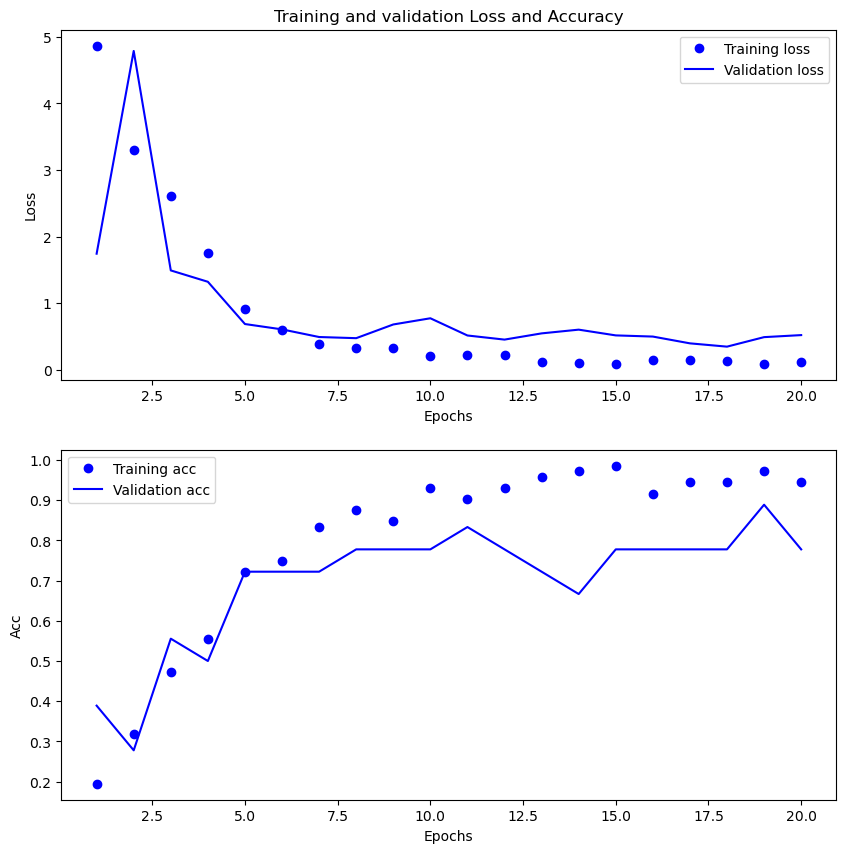

In [15]:
import matplotlib.pyplot as plt
epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values =classifier_dict['accuracy']
val_acc_values = classifier_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
#classes=['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
target_names = class_names


print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

2/2 [==============================] - 3s 1s/step
Classification Report
              precision    recall  f1-score   support

     pupunha       1.00      0.80      0.89         5
    graviola       1.00      0.80      0.89         5
      tucuma       1.00      1.00      1.00         5
     cupuacu       1.00      1.00      1.00         5
     guarana       0.57      0.80      0.67         5
        acai       0.60      0.60      0.60         5

    accuracy                           0.83        30
   macro avg       0.86      0.83      0.84        30
weighted avg       0.86      0.83      0.84        30



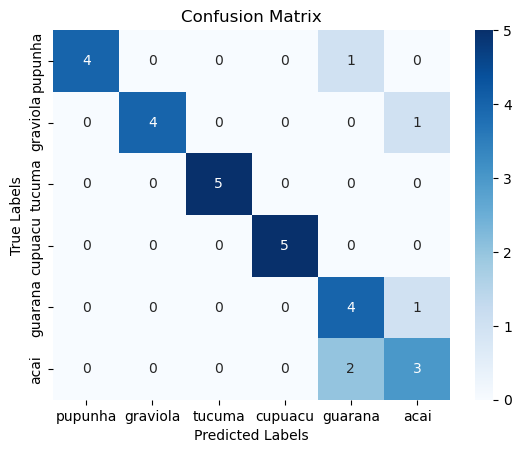

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
model.save('fruits.h5')

In [19]:
from tensorflow.keras.models import load_model
model = load_model('fruits.h5')

In [20]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2/2 [==============================] - 2s 41ms/step - loss: 0.3800 - accuracy: 0.8333
Test loss: 0.38001060485839844
Test accuracy: 0.8333333134651184
